In [58]:
import pandas as pd
import numpy as np

import glob
import os

PROCESSED_PATH = "./Data/ICDAR_SROIE/processed/"

# Loading ocr and label data
receipt_train_img = {os.path.split(x)[-1].replace(".jpg",""):x for x in glob.glob("./Data/ICDAR_SROIE/0325updated.task1train(626p)/*.jpg") if not os.path.split(x)[-1].replace(".jpg","").endswith(")")}

ocr_data = {os.path.split(x)[-1].replace(".txt",""):x for x in glob.glob("./Data/ICDAR_SROIE/0325updated.task1train(626p)/*.txt") if not os.path.split(x)[-1].replace(".txt","").endswith(")")} 
label_data = {os.path.split(x)[-1].replace(".txt",""):x for x in glob.glob("./Data/ICDAR_SROIE/0325updated.task2train(626p)/*.txt") if not os.path.split(x)[-1].replace(".txt","").endswith(")")}

# Checking if all the sets have the same number of labelled data
assert len(receipt_train_img) == len(ocr_data) == len(label_data)

In [2]:
import json
from fuzzywuzzy import fuzz
def extract_ocr_data_fromtxt(file_path, key, save = False):
    """
    Extract the bounding box coordinates from txt and returns a pandas dataframe
    """
    with open(file_path, 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        lines = [line.split(",")[:2] + line.split(",")[4:6] + [",".join(line.split(",")[8:])] for line in stripped if line]
        
        df = pd.DataFrame(lines, columns = ['xmin', 'ymin','xmax', 'ymax','text'])
        # Option to save as a csv
        if save:
            if not os.path.exists(PROCESSED_PATH):
                os.mkdir(PROCESSED_PATH)
            df.to_csv(os.path.join(PROCESSED_PATH,key + '.csv'), index =None)
        return df
            
def extract_label_data_fromtxt(file_path):
    """
    Read the label json and return as a dictionary
    """
    with open(file_path) as f:
        json_data = json.load(f)
        return json_data
    
def map_labels(text,k):
    """
    Maps label to ocr output using certain heuristics and logic
    """
    text_n = None
    k_n = None
    try:
        text_n = float(text)
    except Exception as e:
        pass

    try:
        k_n = float(k)
    except Exception as e:
        pass
    # if both are text then we are doing a fuzzy match
    if (pd.isnull(text_n) and pd.isnull(k_n)):
#         if (text in k) or (k in text):
#             return True
        if fuzz.token_set_ratio(text,k) > 90:
            return True
    # if both are numerical then we just check for complete match
    elif (text_n is not None) and (k_n is not None):
        return text == k
    # special case to handle total, using endwith 
    # as sometimes symbols are attached to ocr output
    elif (k_n is not None) and (text_n is None):
        return text.endswith(k)
    
    return False

C:\Users\bansa\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
def mapped_label_ocr(key):
    """
    Wrapper function to yield result of mapping in desired format
    """
    data = extract_ocr_data_fromtxt(ocr_data[key],key)
    label_dict = extract_label_data_fromtxt(label_data[key])
    
    data['labels'] = [[k for k,v in label_dict.items() if map_labels(text, v)] for text in data.text]
    # To avoid company and address overlap in some cases.
    data['labels'] = ['address' if len(label) > 1 else "".join(label) for label in data['labels']]
    
    if not os.path.exists(PROCESSED_PATH):
        os.mkdir(PROCESSED_PATH)
    data.to_csv(os.path.join(PROCESSED_PATH,key + '.csv'), index =None)
    
    
    return data

In [4]:
mapped_data = {key: mapped_label_ocr(key) for key in ocr_data.keys()}

In [5]:
# Let's plot some of these labels and see the results
import cv2
import matplotlib.pyplot as plt 

LABELLED_IMG = "./Data/ICDAR_SROIE/labelled_img/"
if not os.path.exists(LABELLED_IMG):
    os.mkdir(LABELLED_IMG)

In [10]:
# from PIL import Image

# image = Image.open(receipt_train_img['X00016469612'])
# image

In [7]:
def visualize_labels(key, df, save_img = False):
    """returns invoices with manually annontated labels"""
    
    img = cv2.imread(receipt_train_img[key])


    for i, rows in df.iterrows():                   
            text = rows['labels'].upper() 

            x1,y1,x3,y3 = int(rows['xmin']),int(rows['ymin']),int(rows['xmax']),int(rows['ymax'])

            img = cv2.rectangle(img = img, 
                                pt1 = (x1, y1), 
                                pt2 = (x3, y3), 
                                color = (255, 0, 0),
                               thickness = 1)
            img = cv2.putText(img, text, (x1, y1 - 1),
                        cv2.FONT_HERSHEY_DUPLEX, 0.6, (0, 0, 255), 1)

    if save_img:
        cv2.imwrite(LABELLED_IMG + key + '_withlabels.jpg', img)

In [8]:
mapped_correct_data = {os.path.split(x)[-1].replace(".csv","") : pd.read_csv(x, index_col = None) for x in glob.glob("./Data/ICDAR_SROIE/processed_correct/*.csv")}

In [9]:
for key in mapped_correct_data.keys():
    df = mapped_data[key].dropna().reset_index(drop = True)
#     df = mapped_correct_data[key].dropna().reset_index(drop = True)
    visualize_labels(key, df, save_img = True)

## Create Text Features

In [62]:
PROCESSED_TEXT_PATH = "./Data/ICDAR_SROIE/processed_text_features"

if not os.path.exists(PROCESSED_TEXT_PATH):
    os.mkdir(PROCESSED_TEXT_PATH)

In [96]:
import spacy
import string
import collections
import re
from dateutil.parser import parse
from itertools import groupby

import en_core_web_sm
nlp = en_core_web_sm.load()

def get_text_features(text):
    
    # SpecialCharacterCount  
    special_chars = string.punctuation
    SpecialCharacterCount = np.sum([v for k, v in collections.Counter(text).items() \
                  if k in special_chars])
    
    # isFloat 
    try:
        float(text)
        isFloat = 1
    except Exception as e:
        isFloat = 0
        
    # isDate 
    try: 
        parse(text, fuzzy=True)
        isDate = int(True and len(text) > 5)
    except Exception as e:
        isDate = 0
    
    # TotalDistinctNumber
    num_list = re.findall(r"(\d+)", text)
    num_list = [float(x) for x in num_list]
    
    TotalDistinctNumber = len(num_list)
    
    # BigNumLength 
    BigNumLength = np.max(num_list) if TotalDistinctNumber > 0 else 0
    
    
    # DoesContainsNum 
    DoesContainsNum = 1 if TotalDistinctNumber > 0 else 0
    
    # POSTagDistribution 
    spacy_text = nlp(text)
    pos_list = [token.pos_ for token in spacy_text]
    
    POSTagDistribution = {}
    for k in ['SYM','NUM','CCONJ','PROPN']:
        POSTagDistribution['POSTagDistribution' + k] = [0]
        
    POSTagDistribution.update({'POSTagDistribution'+ value: [len(list(freq))] for value, freq in groupby(sorted(pos_list)) if value in ['SYM','NUM','CCONJ','PROPN']})
    
    pos_features = pd.DataFrame.from_dict(POSTagDistribution)
    other_features = pd.DataFrame([[SpecialCharacterCount, isFloat, isDate,
                                  TotalDistinctNumber, BigNumLength, DoesContainsNum]], 
                                  columns = ["SpecialCharacterCount","isFloat","isDate",
                                                "TotalDistinctNumber","BigNumLength", "DoesContainsNum"])
    
    df = pd.concat([other_features, pos_features], axis = 1)
    return df

    


In [97]:
mapped_data_text_features = {}
for k, v in mapped_data.items():
    _df = pd.concat([get_text_features(x) for x in v.text], axis = 0)
    final_df = pd.concat([v.reset_index(drop = True), _df.reset_index(drop = True)], axis = 1)
    final_df.to_csv(os.path.join(PROCESSED_TEXT_PATH,k+".csv"), index = None)
    mapped_data_text_features[k] = final_df

C:\Users\bansa\AppData\Roaming\Python\Python37\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname JALAN identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\bansa\AppData\Roaming\Python\Python37\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname S identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\bansa\AppData\Roaming\Python\Python37\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname B identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\bansa\App

## Line Formation

In [136]:
import itertools
def get_line_numbers(key):
    """
    Get line number for each word.
    """
    ################ 1 ##################
    
    df = mapped_data_text_features[key]
    df.sort_values(by=['ymin'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # To avoid spacing issue, lets reduce ymax by some small value
    df["ymax"] = df["ymax"].apply(lambda x: int(x) - 0.5)
    
    
    ################ 2 ##################
    # In order to get line number we start with left most word/phrase/node 
    # and then check all non-matching words and store their indices from L->R
    word_idx = []
    for i, row in df.iterrows():
        flattened_word_idx = list(itertools.chain(*word_idx))
        # check if the word has not already been checked
        if i not in flattened_word_idx:
            top_wa = int(row['ymin'])
            bottom_wa = int(row['ymax'])

            # Store the word
            idx = [i]
        
            for j, row_dash in df.iterrows():
                if j not in flattened_word_idx:
                # check a different word, double check
                    if not i == j:
                        top_wb = int(row_dash['ymin'])
                        bottom_wb = int(row_dash['ymax'] )
                        # Valid for all the words next to Wax
                        if (top_wa <= bottom_wb) and (bottom_wa >= top_wb): 
                            idx.append(j)
            word_idx.append(idx)
    
    # Create line number for each node

    word_df = pd.DataFrame([[j,i+1] for i,x in enumerate(word_idx) for j in x], columns= ["word_index","line_num"])
    
    # put the line numbers back to the list
    final_df = df.merge(word_df, left_on=df.index, right_on='word_index')
    final_df.drop('word_index', axis=1, inplace=True)
    
    
    ################ 3 ##################
    final_df = final_df.sort_values(by=['line_num','xmin'],ascending=True)\
            .groupby('line_num').head(len(final_df))\
            .reset_index(drop=True)
    final_df['word_id'] = list(range(len(final_df)))


    return final_df
    
    

In [138]:
mapped_data_text_features_line = {key:get_line_numbers(key) for key,_ in mapped_data_text_features.items()}

## Graphing Algo

In [139]:
GRAPH_IMAGE_PATH = "./Data/ICDAR_SROIE/processed_graph_images"

if not os.path.exists(GRAPH_IMAGE_PATH):
    os.mkdir(GRAPH_IMAGE_PATH)

In [185]:
class NetworkData():
    def __init__(self, final_connections, G, df):
        self.final_connections = final_connections
        self.G = G
        self.df = df
    def get_connection_list():
        return self.final_connections
    def get_networkx_graph():
        return self.G
    def get_processed_data():
        return self.df        

In [215]:
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
def graph_modelling(key, save_graph =False):

    # Horizontal edge formation   
   
    df = mapped_data_text_features_line[key]
    df_grouped = df.groupby('line_num')
    
    # for directed graph
    left_connections = {}    
    right_connections = {}

    for _,group in df_grouped:
        wa = group['word_id'].tolist()        
        #2
        # In case of a single word in a line this will be an empty dictionary
        _right_dict = {wa[i]:{'right':wa[i+1]} for i in range(len(wa)-1) }
        _left_dict = {wa[i+1]:{'left':wa[i]} for i in range(len(wa)-1) }


        #add the indices in the dataframes
        for i in range(len(wa)-1):
            df.loc[df['word_id'] == wa[i], 'right'] = int(wa[i+1])
            df.loc[df['word_id'] == wa[i+1], 'left'] = int(wa[i])
    
        left_connections.update(_left_dict)
        right_connections.update(_right_dict)

    # Vertical edge formation
    bottom_connections = {}
    top_connections = {}

    for i, row in df.iterrows():
        if i not in bottom_connections.keys():
            for j, row_dash in df.iterrows():

                # since our dataframe is sorted by line number and we are looking for vertical connections
                # we will make sure that we are only searching for a word/phrase next in row.
                if j not in bottom_connections.values() and i < j:
                    if row_dash['line_num'] > row['line_num']: 
                        bottom_connections[i] = j

                        top_connections[j] = i

                        #add it to the dataframe
                        df.loc[df['word_id'] == i , 'bottom'] = j
                        df.loc[df['word_id'] == j, 'top'] = i 

                        # break once the condition is met
                        break 


    # Merging Neighbours from all 4 directions 
    final_connections = {}
    
    # Taking all the keys that have a connection in either horizontal or vertical direction
    # Note : Since these are undirected graphs we can take either of (right, left) OR (top, bottom)
    for word_ids in (right_connections.keys() | bottom_connections.keys()):
        if word_ids in right_connections: final_connections.setdefault(word_ids, []).append(right_connections[word_ids]['right'])
        if word_ids in bottom_connections: final_connections.setdefault(word_ids, []).append(bottom_connections[word_ids])

    # Create a networkx graph for ingestion into stellar graph model
    G = nx.from_dict_of_lists(final_connections)
    
    # Adding node features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df[['SpecialCharacterCount', 'isFloat', 'isDate', 'TotalDistinctNumber',
       'BigNumLength', 'DoesContainsNum', 'POSTagDistributionSYM',
       'POSTagDistributionNUM', 'POSTagDistributionCCONJ',
       'POSTagDistributionPROPN', 'line_num']])
    node_feature_map = {y:x for x,y in zip(scaled_features, df.word_id)}
    
    for node_id, node_data in G.nodes(data=True):
        node_data["feature"] = node_feature_map[node_id]

    if save_graph:
        # There are multiple layouts but KKL is most suitable for non-centric layout
        layout = nx.kamada_kawai_layout(G) 
        
        # Plotting the Graphs
        plt.figure(figsize=(10,5))
        # Get current axes
        ax = plt.gca()
        ax.set_title(f'Graph form of {key}')        
        nx.draw(G, layout, with_labels=True)
        plt.savefig(os.path.join(GRAPH_IMAGE_PATH, key +".jpg"), format="JPG")
        plt.close()
    
    networkobject = NetworkData(final_connections, G, df)
    return networkobject 



In [216]:
mapped_net_obj = {key: graph_modelling(key, save_graph=True) for key,_ in mapped_data_text_features_line.items()}

## Input Data Pipeline

In [228]:
U = nx.union_all([obj.G for k,obj in mapped_net_obj.items()], rename=[k+"-" for k in mapped_net_obj.keys()])

## Modelling

In [264]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection

In [290]:
G_sg = sg.StellarGraph.from_networkx(U, node_features="feature")
print(G_sg.info())

StellarGraph: Undirected multigraph
 Nodes: 33626, Edges: 46820

 Node types:
  default: [33626]
    Features: float32 vector, length 11
    Edge types: default-default->default

 Edge types:
    default-default->default: [46820]
        Weights: all 1 (default)
        Features: none


In [291]:
labelled_data = pd.DataFrame([[k+"-"+str(node_idx), label] 
                 for k,obj in mapped_net_obj.items()\
                for node_idx,label in zip(obj.df.word_id,obj.df.labels)],
                             columns = ["node_id","node_target"])

labelled_data = labelled_data.replace(r'^\s*$', "others", regex=True)

In [292]:
print(labelled_data.node_target.value_counts().reset_index().to_markdown())

|    | index   |   node_target |
|---:|:--------|--------------:|
|  0 | others  |         28861 |
|  1 | address |          1692 |
|  2 | total   |          1562 |
|  3 | date    |           764 |
|  4 | company |           747 |


In [293]:
train,val = model_selection.train_test_split(labelled_data, random_state = 42,
                                            train_size = 0.8, stratify = labelled_data.node_target)

In [294]:
# Encoding the targets
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train.node_target)
val_targets = target_encoding.fit_transform(val.node_target)

In [295]:
generator = FullBatchNodeGenerator(G_sg)

Using GCN (local pooling) filters...


In [296]:
train_flow = generator.flow(train.node_id, train_targets)
val_flow = generator.flow(val.node_id, val_targets)

In [297]:
# Model Formation
# two layers of GCN
gcn = GCN(layer_sizes=[8, 4], activations=["selu", "selu"], generator=generator, dropout=0.5)
# expose in and out to create keras model
x_inp, x_out = gcn.in_out_tensors()

# usual output layer
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

# define model
model = Model(inputs=x_inp, outputs=predictions)
# compile model
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["AUC"])

In [298]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(1, 33626, 11)]     0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(1, None, 2)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(1, None)]          0                                            
__________________________________________________________________________________________________
dropout_4 (Dropout)             (1, 33626, 11)       0           input_9[0][0]                    
____________________________________________________________________________________________

In [301]:
from tensorflow.keras.callbacks import EarlyStopping
es_callback = EarlyStopping(monitor="val_auc", patience=10, restore_best_weights=True)

history = model.fit(
    train_flow,
    epochs=50,
    validation_data=val_flow,
    verbose=2,
    callbacks=[es_callback])

Epoch 1/50
1/1 - 0s - loss: 0.8570 - auc: 0.9123 - val_loss: 0.7554 - val_auc: 0.9113
Epoch 2/50
1/1 - 0s - loss: 0.7999 - auc: 0.9122 - val_loss: 0.7082 - val_auc: 0.9105
Epoch 3/50
1/1 - 0s - loss: 0.7583 - auc: 0.9104 - val_loss: 0.6720 - val_auc: 0.9099
Epoch 4/50
1/1 - 0s - loss: 0.7186 - auc: 0.9109 - val_loss: 0.6474 - val_auc: 0.9093
Epoch 5/50
1/1 - 0s - loss: 0.6930 - auc: 0.9109 - val_loss: 0.6338 - val_auc: 0.9088
Epoch 6/50
1/1 - 0s - loss: 0.6774 - auc: 0.9102 - val_loss: 0.6298 - val_auc: 0.9086
Epoch 7/50
1/1 - 0s - loss: 0.6690 - auc: 0.9108 - val_loss: 0.6331 - val_auc: 0.9086
Epoch 8/50
1/1 - 0s - loss: 0.6710 - auc: 0.9096 - val_loss: 0.6412 - val_auc: 0.9086
Epoch 9/50
1/1 - 0s - loss: 0.6717 - auc: 0.9110 - val_loss: 0.6515 - val_auc: 0.9089
Epoch 10/50
1/1 - 0s - loss: 0.6787 - auc: 0.9114 - val_loss: 0.6617 - val_auc: 0.9093
Epoch 11/50
1/1 - 4s - loss: 0.6886 - auc: 0.9107 - val_loss: 0.6702 - val_auc: 0.9095
Epoch 12/50
1/1 - 0s - loss: 0.6933 - auc: 0.9118 - 

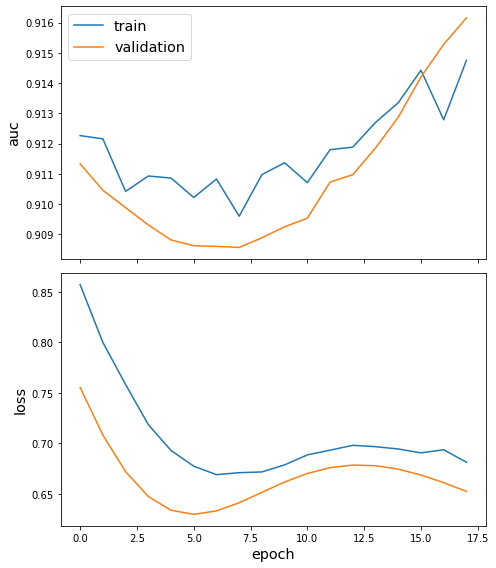

In [302]:
sg.utils.plot_history(history)

In [286]:
# Fit with class imbalance corrected
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labelled_data.node_target),
                                                 labelled_data.node_target)
assert all(target_encoding.classes_ == np.unique(labelled_data.node_target))

In [ ]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)